# Collapsed Gibbs sampler for supervised latent Dirichlet allocation

<div style="display:none">
  $
      \newcommand{\dir}{\mathop{\rm Dirichlet}\nolimits}
      \newcommand{\dis}{\mathop{\rm Discrete}\nolimits}
      \newcommand{\normal}{\mathop{\rm Normal}\nolimits}
      \newcommand{\ber}{\mathop{\rm Bernoulli}\nolimits}
      \newcommand{\btheta}{\mathbf{\theta}}
      \newcommand{\norm}[1]{\left\| #1 \right\|}
      \newcommand{\cp}[2]{p \left( #1 \middle| #2 \right)}
      \newcommand{\cN}[2]{\mathscr{N} \left( #1 \middle| #2 \right)}
      \newcommand{\Betaf}{\mathop{\rm B}\nolimits}
      \newcommand{\Gammaf}{\mathop{\Gamma}\nolimits}
      \newcommand{\etd}[1]{\mathbf{z}^{(#1)}}
      \newcommand{\sumetd}{\mathbf{z}}
      \newcommand{\one}{\mathbf{1}}
  $
</div>

Here is the collapsed Gibbs sampler for Blei and McAuliffe's [supervised topic models](https://www.cs.princeton.edu/~blei/papers/BleiMcAuliffe2007.pdf).  I am building on the [collapsed Gibbs sampler](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) I wrote for latent Dirichlet allocation.

The generative model for  is as follows:

$$\begin{align}
\theta^{(d)} &\sim \dir(\alpha) &\text{(topic distribution for document $d \in \{1, \ldots, D\}$)} \\
\phi^{(k)} &\sim \dir(\beta) &\text{(term distribution for topic $k \in \{1, \ldots, K\}$)} \\
z_n^{(d)} \mid \theta^{(d)} &\sim \dis \left( \theta^{(d)} \right) &\text{(topic of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)} \\
w_n^{(d)} \mid \phi^{(z_n^{(d)})} &\sim \dis \left( \phi^{(z_n^{(d)})} \right) &\text{(term of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)} \\
\eta_k &\sim \normal \left( \mu, \nu^2 \right) &\text{(regression coefficient for topic $k \in \{1, \ldots, K\}$)} \\
y^{(d)} \mid \eta, \etd{d} &\sim \normal \left( \eta \cdot \etd{d}, \sigma^2 \right) &\text{(response value of document $d \in \{1, \ldots, D\}$)}
\end{align}$$

where each token can be any one of $V$ terms in our vocabulary, and $\etd{d}$ is the empirical topic distribution of document $d$.

<img src="http://www.mdpi.com/remotesensing/remotesensing-05-02275/article_deploy/html/images/remotesensing-05-02275f2-1024.png" width="400">

<p style='text-align: center; font-style: italic;'>
Plate notation for supervised latent Dirichlet allocation.
<br/>
This diagram should replace $\beta_k$ with $\phi^{(k)}$, and each $\phi^{(k)}$ should be dependent on a single $\beta$.
</p>

The joint probability distribution can be factored as follows:

$$\begin{align}
\cp{\theta, \phi, z, w, \eta, y}{\alpha, \beta, \mu, \nu^2, \sigma^2}
&= 
\prod_{k=1}^{K} \cp{\phi^{(k)}}{\beta}
\prod_{d=1}^{D} \cp{\theta^{(d)}}{\alpha}
\prod_{n=1}^{N^{(d)}} \cp{z_n^{(d)}}{\theta^{(d)}} \cp{w_n^{(d)}}{\phi^{(z_n^{(d)})}}
\\ & \quad \times \prod_{k'=1}^{K} \cp{\eta_{k'}}{\mu, \nu^2}
\prod_{d'=1}^D \cp{y^{(d')}}{\eta, \etd{d'}, \sigma^2}
\\ &=
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)} \cp{\phi^{(k)}}{b^{(k)} + \beta}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)} \cp{\theta^{(d)}}{a^{(d)} + \alpha}
\\ &\quad \times
\prod_{k'=1}^{K} \cN{\eta_{k'}}{\mu, \nu^2} 
\prod_{d'=1}^{D} \cN{y^{(d')}}{\eta \cdot \etd{d'}, \sigma^2}
\end{align}$$

where $a_k^{(d)}$ is the number of tokens in document $d$ assigned to topic $k$, $b_v^{(k)}$ is the number of tokens equal to term $v$ and assigned to topic $k$, and $\Betaf$ is the [multivariate Beta function](https://en.wikipedia.org/wiki/Beta_function#Multivariate_beta_function). Marginalizing out $\theta$ and $\phi$ by integrating with respect to each $\theta^{(d)}$ and $\phi^{(k)}$ over their respective sample spaces yields

$$\begin{align}
\cp{z, w, \eta, y}{\alpha, \beta, \mu, \nu^2, \sigma^2} &= 
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)}
\prod_{k'=1}^{K} \cN{\eta_{k'}}{\mu, \nu^2} 
\prod_{d'=1}^{D} \cN{y^{(d')}}{\eta \cdot \etd{d'}, \sigma^2} \\ &=
\cp{w}{z, \beta} \cp{z}{\alpha} \cp{\eta}{\mu, \nu^2} \cp{y}{\eta, z, \sigma^2}.
\end{align}$$

See my [LDA notebook](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) for step-by-step details of the previous two calculations.

Our goal is to calculate the posterior distribution

$$\cp{z, \eta}{w, y, \alpha, \beta, \mu, \nu^2, \sigma^2} =
\frac{\cp{z, w, \eta, y}{\alpha, \beta, \mu, \nu^2, \sigma^2}}
{\sum_{z'} \int \cp{z', w, \eta', y}{\alpha, \beta, \mu, \nu^2, \sigma^2} d\eta'}$$

in order to infer the topic assignments $z$ and regression coefficients $\eta$ from the given term assignments $w$ and response data $y$.  Since calculating this directly is infeasible, we resort to collapsed Gibbs sampling.  The sampler is "collapsed" because we marginalized out $\theta$ and $\phi$, and will estimate them from the topic assignments $z$:

$$\hat\theta_k^{(d)} = \frac{a_k^{(d)} + \alpha_k}{\sum_{k'=1}^K \left(a_{k'}^{(d)} + \alpha_{k'} \right)},\quad
\hat\phi_v^{(k)} = \frac{b_v^{(k)} + \beta_v}{\sum_{v'=1}^V \left(b_{v'}^{(k)} + \beta_{v'} \right)}.$$

Gibbs sampling requires us to compute the full conditionals for each $z_n^{(d)}$ and $\eta_k$, i.e. we need to calculate, for all $n$, $d$ and $k$,

$$\begin{align}
\cp{z_n^{(d)} = k}{z \setminus z_n^{(d)}, w, \eta, y, \alpha, \beta, \mu, \nu^2, \sigma^2}
&\propto
\cp{z_n^{(d)} = k, z \setminus z_n^{(d)}, w, \eta, y}{\alpha, \beta, \mu, \nu^2, \sigma^2}
\\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)
\prod_{d'=1}^{D} \cN{y^{(d')}}{\eta \cdot \etd{d'}, \sigma^2}
\\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)
\exp \left( \frac{1}{2 \sigma^2} \frac{\eta_k}{N^{(d)}} \left( 2 \left[ y^{(d)} - \eta \cdot \left( \etd{d} \setminus z_n^{(d)} \right) \right] - \frac{\eta_k}{N^{(d)}} \right) \right)
\end{align}$$

where the "set-minus" notation $\cdot \setminus z_n^{(d)}$ denotes the variable the notation is applied to with the entry $z_n^{(d)}$ removed (again, see my [LDA notebook](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) for details).  This final proportionality is true since

$$\begin{align}
\prod_{d'=1}^{D} \cN{y^{(d')}}{\eta \cdot \etd{d'}, \sigma^2}
&\propto
\prod_{d'=1}^{D} \exp \left( -\frac{ \left( y^{(d')} - \eta \cdot \etd{d'} \right)^2 }{2 \sigma^2} \right) 
\\ &\propto
\prod_{d'=1}^{D} \exp \left( \frac{ 2 y^{(d')} \eta \cdot \etd{d'} - \left( \eta \cdot \etd{d'} \right)^2 }{2 \sigma^2} \right) 
\\ &=
\prod_{d'=1}^{D} \exp \left( \frac{ 2 y^{(d')} \left( \eta \cdot \left( \etd{d'} \setminus z_n^{(d)} \right) + \delta_{d, d'} \frac{\eta_k}{N^{(d)}} \right) - \left( \eta \cdot \left( \etd{d'} \setminus z_n^{(d)} \right) + \delta_{d, d'} \frac{\eta_k}{N^{(d)}} \right)^2 }{2 \sigma^2} \right) 
\\ &=
\prod_{d'=1}^{D} \exp \left( \frac{ 2 y^{(d')} \eta \cdot \left( \etd{d'} \setminus z_n^{(d)} \right) - \left( \eta \cdot \left( \etd{d'} \setminus z_n^{(d)} \right) \right)^2 }{2 \sigma^2} \right)
\exp \left( \frac{1}{2 \sigma^2} \frac{\eta_k}{N^{(d)}} \left( 2 \left[ y^{(d)} - \eta \cdot \left( \etd{d} \setminus z_n^{(d)} \right) \right] - \frac{\eta_k}{N^{(d)}} \right) \right)
\\ &\propto
\exp \left( \frac{1}{2 \sigma^2} \frac{\eta_k}{N^{(d)}} \left( 2 \left[ y^{(d)} - \eta \cdot \left( \etd{d} \setminus z_n^{(d)} \right) \right] - \frac{\eta_k}{N^{(d)}} \right) \right)
\end{align}$$

where $\delta_{d, d'}$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).

We also need to calculate the full conditional for $\eta$.  In order to do this, let $Z = (\etd{1} \cdots \etd{D})$ be the matrix whose columns are the empirical topic distributions $\etd{d}$, let $I$ be the identity matrix and $\one$ be the vector of ones, and note that

$$\prod_{k=1}^{K} \cN{\eta_{k}}{\mu, \nu^2} = \cN{\eta}{\mu \one, \nu^2 I}$$
$$\prod_{d=1}^{D} \cN{y^{(d)}}{\eta \cdot \etd{d'}, \sigma^2} = \cN{y}{Z^T \eta, \sigma^2 I}.$$

Therefore

$$\begin{align}
\cp{\eta}{z, w, y, \alpha, \beta, \mu, \nu^2, \sigma^2}
&\propto
\cp{z, w, \eta, y}{\alpha, \beta, \mu, \nu^2, \sigma^2}
\\ &\propto
\cN{\eta}{\mu \one, \nu^2 I} \cN{y}{Z^T \eta, \sigma^2 I}
\\ &\propto
\cN{\eta}{\Sigma \left( \nu^{-2} \mu \one + \sigma^{-2} Zy \right), \Sigma}
\end{align}$$

where $\Sigma^{-1} = \nu^{-2} I + \sigma^{-2} ZZ^T$ (see Section 9.3 of [Kevin Murphy's notes](http://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall07/reading/gauss.pdf) for a derivation of Bayes rule for linear Gaussian systems).  It is interesting to consider the mean and variance of $\eta$ in the two variance regimes $\sigma \gg \nu$ and $\sigma \ll \nu$.  If $\sigma \gg \nu$, then

$$\Sigma^{-1} = \nu^{-2} \left( I + \left( \frac{\nu}{\sigma} \right)^2 ZZ^T \right)
\approx \nu^{-2} I$$

which implies that the covariance structure of $\eta$ is $\Sigma \approx \nu^2 I$ and the mean of $\eta$ is

$$\Sigma \left( \nu^{-2} \mu \one + \sigma^{-2} Zy \right)
\approx \mu \one + \left( \frac{\nu}{\sigma} \right)^2 Zy
\approx \mu \one,$$

thus $\eta$ is approximately distributed according to its prior distribution.  On the other hand, if $\sigma \ll \nu$, then

$$\Sigma^{-1} = \sigma^{-2} \left( \left( \frac{\sigma}{\nu} \right)^2 I + ZZ^T \right)
\approx \sigma^{-2} ZZ^T.$$

Notice that $ZZ^T$ is almost surely positive definite, and hence almost surely invertible.  Therefore $\Sigma \approx \sigma^2 (ZZ^T)^{-1}$ and 

$$\Sigma \left( \nu^{-2} \mu \one + \sigma^{-2} Zy \right)
\approx \left( \frac{\sigma}{\nu} \right)^2 \mu (ZZ^T)^{-1} \one + (ZZ^T)^{-1} Zy
\approx (ZZ^T)^{-1} Zy,$$

thus $\eta$ is approximately distributed as the least-squares solution of $y = Z^T \eta$.

## Graphical test 

In [2]:
%matplotlib inline

from modules.helpers import plot_images
from functools import partial
from sklearn.metrics import (mean_squared_error)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

imshow = partial(plt.imshow, cmap='gray', interpolation='nearest', aspect='auto')
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
sns.set(style='white')

### Generate topics 

We assume a vocabulary of 25 terms, and create ten "topics", where each topic assigns exactly 5 consecutive terms equal probability.

In [3]:
V = 25
K = 10
N = 100
D = 1000

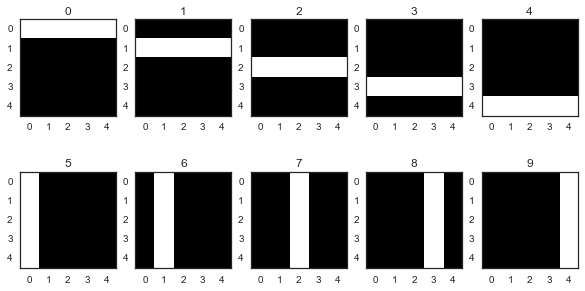

In [4]:
topics = []
topic_base = np.concatenate((np.ones((1, 5)) * 0.2, np.zeros((4, 5))), axis=0).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i * 5))
topic_base = np.concatenate((np.ones((5, 1)) * 0.2, np.zeros((5, 4))), axis=1).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)
plt.figure(figsize=(10, 5))
plot_images(plt, topics, (5, 5), layout=(2, 5), figsize=(10, 5))

### Generate documents from topics

We generate 1,000 documents from these 10 topics by sampling 1,000 topic distributions, one for each document, from a Dirichlet distribution with parameter $\alpha = (1, \ldots, 1)$.

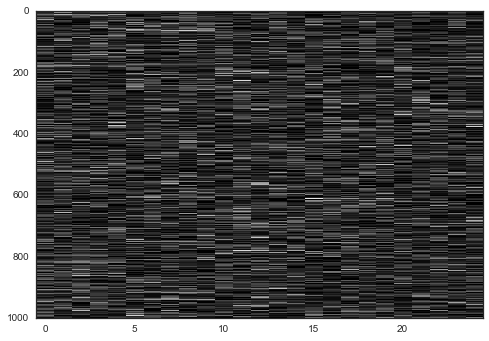

In [5]:
alpha = np.ones(K)
np.random.seed(42)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=100, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
imshow(doc_term_matrix)

### Generate responses

[  4.96714153  -1.38264301   6.47688538  15.23029856  -2.34153375
  -2.34136957  15.79212816   7.67434729  -4.69474386   5.42560044]


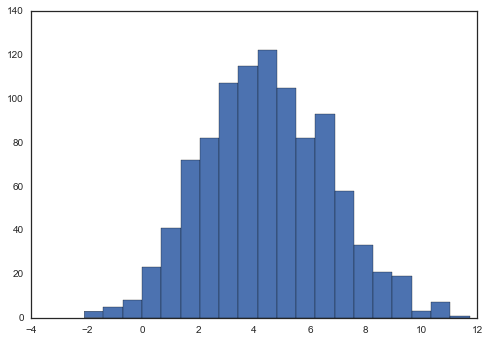

In [6]:
# choose parameter values
nu2 = 10
sigma2 = 1
np.random.seed(42)
eta = np.random.normal(scale=nu2, size=K)
y = [np.dot(eta, thetas[i]) for i in range(D)] + np.random.normal(scale=sigma2, size=D)
# plot histogram of responses
print(eta)
_ = plt.hist(y, bins=20)

### Estimate parameters

In [7]:
from slda.topic_models import SLDA

In [9]:
_K = 10
_alpha = alpha
_beta = np.repeat(0.01, V)
_mu = 0
_nu2 = nu2
_sigma2 = sigma2
n_iter = 500
slda = SLDA(_K, _alpha, _beta, _mu, _nu2, _sigma2, n_iter, seed=42)

In [10]:
%%time
slda.fit(doc_term_matrix, y)

CPU times: user 12.7 s, sys: 23.3 ms, total: 12.8 s
Wall time: 12.8 s


[[  2.09449783e-01   1.00358783e-06   1.00358783e-06   1.00358783e-06
    1.00358783e-06   1.92188072e-01   1.00358783e-06   1.00358783e-06
    1.00358783e-06   1.00358783e-06   1.85965828e-01   1.00358783e-06
    1.10495020e-03   1.00358783e-06   1.00358783e-06   1.88876233e-01
    1.00358783e-06   1.00358783e-06   1.00358783e-06   1.00358783e-06
    2.22396066e-01   1.00358783e-06   1.00358783e-06   1.00358783e-06
    1.00358783e-06]
 [  1.94239884e-01   1.85987570e-01   2.05277355e-01   1.99810197e-01
    2.10331898e-01   1.03153931e-06   1.03153931e-06   1.03153931e-06
    1.03153931e-06   1.03153931e-06   1.03153931e-06   1.03153931e-06
    1.03153931e-06   1.03153931e-06   1.03153931e-06   1.03153931e-06
    1.03153931e-06   1.03153931e-06   4.33349666e-03   1.03153931e-06
    1.03153931e-06   1.03153931e-06   1.03153931e-06   1.03153931e-06
    1.03153931e-06]
 [  9.45067927e-07   9.45067927e-07   9.45067927e-07   9.45067927e-07
    9.45067927e-07   2.01205907e-01   2.02339988e-

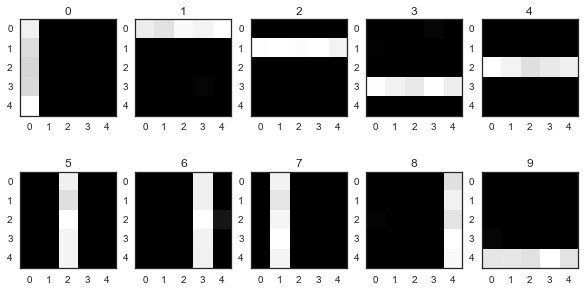

In [11]:
plot_images(plt, slda.phi, (5, 5), (2, 5), figsize=(10, 5))
print(slda.phi)
print(np.sum(slda.phi, axis=0))
print(np.sum(slda.phi, axis=1))

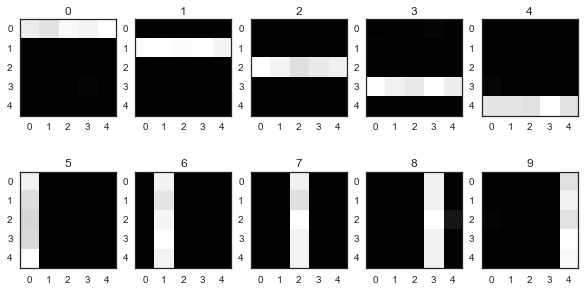

In [12]:
topic_order = [1, 2, 4, 3, 9, 0, 7, 5, 6, 8]
plot_images(plt, slda.phi[topic_order], (5, 5), (2, 5), figsize=(10, 5))

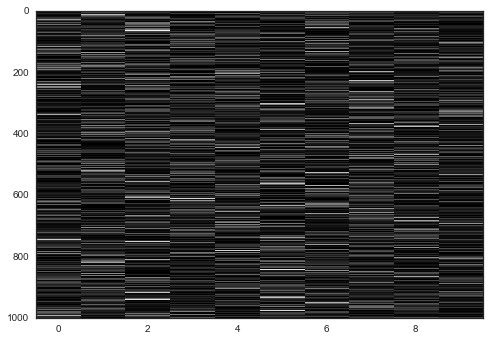

In [13]:
imshow(slda.theta)

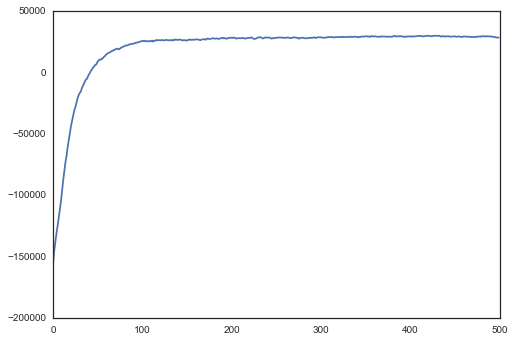

In [14]:
plt.plot(slda.loglikelihoods)

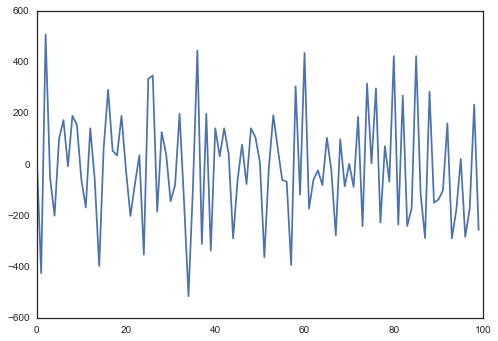

In [15]:
plt.plot(np.diff(slda.loglikelihoods)[-100:])

In [13]:
burn_in = max(n_iter - 100, int(n_iter / 2))
slda.loglikelihoods[burn_in:].mean()

29182.323844355378

In [14]:
eta_pred = slda.eta[burn_in:].mean(axis=0)
print(eta)
print(eta_pred[topic_order])
np.linalg.norm(eta - eta_pred[topic_order])

[  4.96714153  -1.38264301   6.47688538  15.23029856  -2.34153375
  -2.34136957  15.79212816   7.67434729  -4.69474386   5.42560044]
[  4.44236917  -1.37428922   5.69171791  13.92661777  -1.90987367
  -1.35671636  15.39498326   7.42637763  -2.77220459   4.94725851]


2.8091957908971406

### Predict response of test documents

Create 1,000 test documents using the same generative process as our training documents, and compute their actual responses.

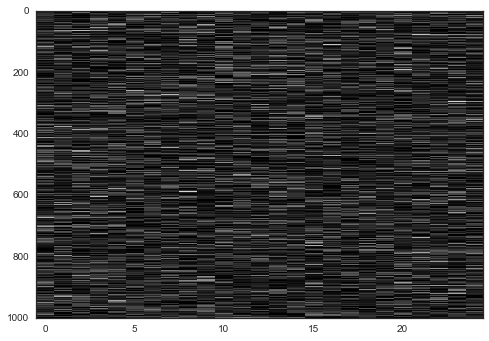

In [15]:
np.random.seed(42^2)
thetas_test = np.random.dirichlet(np.ones(K), size=D)
topic_assignments_test = np.array([np.random.choice(range(K), size=100, p=theta)
                                   for theta in thetas_test])
word_assignments_test = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments_test[d, n]])[0]
                                   for n in range(N)] for d in range(D)])
doc_term_matrix_test = np.array([np.histogram(word_assignments_test[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
y_test = [np.dot(eta, thetas_test[i]) for i in range(D)]
imshow(doc_term_matrix_test)

Estimate their topic distributions using the trained model, then calculate the predicted responses using the mean of our samples of $\eta$ after burn-in as an estimate for $\eta$.

In [16]:
thetas_test_slda = slda.transform(doc_term_matrix_test)
y_slda = [np.dot(eta_pred, thetas_test_slda[i]) for i in range(D)]

Measure the goodness of our prediction using [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation).

In [17]:
rmse(y_test, y_slda)

0.82113166468454046

### Two-step learning: learn topics, then learn regression

In [18]:
from slda.topic_models import LDA

In [19]:
lda = LDA(_K, _alpha, _beta, n_iter, seed=42)

In [20]:
%%time
lda.fit(doc_term_matrix)

2016-06-10 13:13:01.718094 start iterations
2016-06-10 13:13:01.810971 0:00:00.092877 elapsed, iter   10, LL -518559.0163, 8.97% change from last
2016-06-10 13:13:01.886179 0:00:00.168085 elapsed, iter   20, LL -468960.0555, 9.56% change from last
2016-06-10 13:13:01.956784 0:00:00.238690 elapsed, iter   30, LL -445434.0461, 5.02% change from last
2016-06-10 13:13:02.026697 0:00:00.308603 elapsed, iter   40, LL -429314.6963, 3.62% change from last
2016-06-10 13:13:02.099862 0:00:00.381768 elapsed, iter   50, LL -419699.1884, 2.24% change from last
2016-06-10 13:13:02.167735 0:00:00.449641 elapsed, iter   60, LL -415442.5080, 1.01% change from last
2016-06-10 13:13:02.234883 0:00:00.516789 elapsed, iter   70, LL -408896.4141, 1.58% change from last
2016-06-10 13:13:02.301891 0:00:00.583797 elapsed, iter   80, LL -402998.4074, 1.44% change from last
2016-06-10 13:13:02.368526 0:00:00.650432 elapsed, iter   90, LL -398554.0889, 1.10% change from last
2016-06-10 13:13:02.437271 0:00:00.719

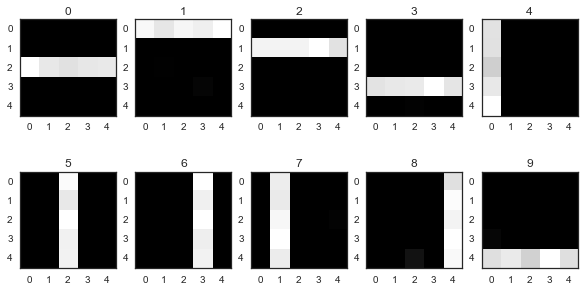

In [21]:
plot_images(plt, lda.phi, (5, 5), (2, 5), figsize=(10, 5))

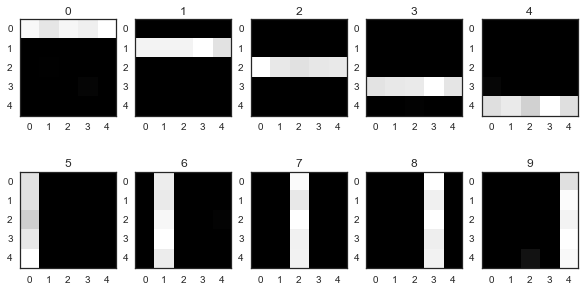

In [22]:
topic_order_lda = [1, 2, 0, 3, 9, 4, 7, 5, 6, 8]
plot_images(plt, lda.phi[topic_order_lda], (5, 5), (2, 5), figsize=(10, 5))

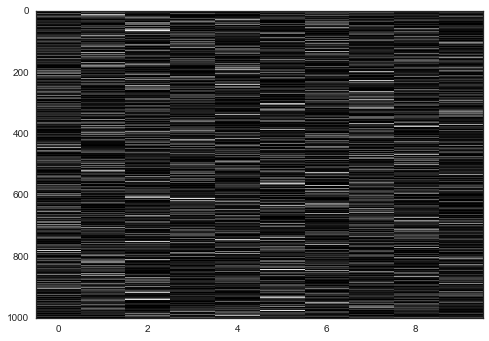

In [23]:
imshow(lda.theta)

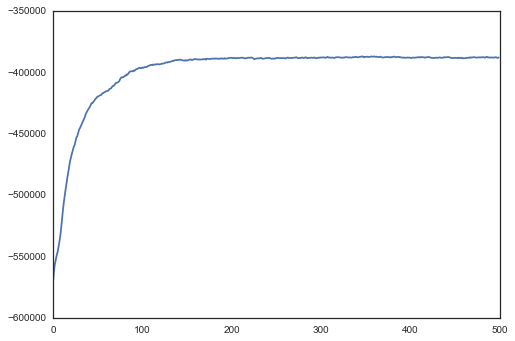

In [24]:
plt.plot(lda.loglikelihoods)

In [25]:
thetas_test_lda = lda.transform(doc_term_matrix_test)

#### Unregularized linear regression

- train linear regression on training data
- calculate response on test data
- measure the goodness of prediction using root mean square error.

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
lr = LinearRegression(fit_intercept=False)
lr.fit(lda.theta, y)
y_lr = lr.predict(thetas_test_lda)
rmse(y_test, y_lr)

0.82647226636711646

In [28]:
print(eta)
print(lr.coef_[topic_order_lda])
np.linalg.norm(eta - lr.coef_[topic_order_lda])

[  4.96714153  -1.38264301   6.47688538  15.23029856  -2.34153375
  -2.34136957  15.79212816   7.67434729  -4.69474386   5.42560044]
[  4.29349447  -1.35662767   5.86690601  13.56743486  -2.225693    -1.3096669
  15.68197752   7.74802135  -2.83164145   4.58107028]


2.978496259038288

#### L2-regularized linear regression

- train ridge regression on training data
- calculate response on test data
- measure the goodness of prediction using root mean square error.

In [29]:
from sklearn.linear_model import Ridge

In [30]:
lrl2 = Ridge(alpha=1., fit_intercept=False)
lrl2.fit(lda.theta, y)
y_lrl2 = lrl2.predict(thetas_test_lda)
rmse(y_test, y_lrl2)

0.86174658080698563

In [31]:
print(eta)
print(lrl2.coef_[topic_order_lda])
np.linalg.norm(eta - lrl2.coef_[topic_order_lda])

[  4.96714153  -1.38264301   6.47688538  15.23029856  -2.34153375
  -2.34136957  15.79212816   7.67434729  -4.69474386   5.42560044]
[  4.28631637  -0.95278145   5.67416731  12.66995942  -1.48722133
  -0.7396339   14.37412703   7.40026967  -2.0793953    4.49485813]


4.5755413457461787

#### Gradient boosted regression trees

- train gradient boosted regressor on training data
- calculate response on test data
- measure the goodness of prediction using root mean square error.

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
gbr = GradientBoostingRegressor()
gbr.fit(lda.theta, y)
y_gbr = gbr.predict(thetas_test_lda)
rmse(y_test, y_gbr)

0.98198962236756349

### Conclusion

SLDA is slightly better than unregularized linear regression, and better than ridge regression or gradient boosted regression trees.  The similar performance to unregularized linear regression is likely due to the fact that this test was set up as an exact problem - all parameters used in training, except $\beta$ (because we hand-picked the topics) and $\eta$ (because that was the one parameter we wanted to learn), were those used to generate documents, and in SLDA the likelihood of $y$ introduces a regularization on $\eta$ in the full-conditional for $z$, while unregularized linear regression does not enforce such a penalty.

## Test with fewer topics

We now redo the previous test, but this time with fewer topics, in order to determine whether

1. the supervised portion of SLDA will produce topics different from those produced by LDA, and
1. prediction with SLDA is improved over LDA-and-a-regression.

Because we will no longer be solving an exact problem (the number of topics, and hence $\alpha$, will both be different from the document generation process), we expect SLDA to do better than LDA-and-a-regression, including unregularized linear regression.

In [34]:
_K = 5
_alpha = np.repeat(1. / _K, _K)
_beta = np.repeat(0.01, V)
_mu = 0
_nu2 = nu2
_sigma2 = sigma2
n_iter = 500
slda1 = SLDA(_K, _alpha, _beta, _mu, _nu2, _sigma2, n_iter, seed=42)

In [35]:
%%time
slda1.fit(doc_term_matrix, y)

2016-06-10 13:13:08.127915 start iterations
2016-06-10 13:13:08.283610 0:00:00.155695 elapsed, iter   10, LL -48424.3678, 57.47% change from last
2016-06-10 13:13:08.426567 0:00:00.298652 elapsed, iter   20, LL -26669.8841, 44.92% change from last
2016-06-10 13:13:08.565257 0:00:00.437342 elapsed, iter   30, LL -23012.4319, 13.71% change from last
2016-06-10 13:13:08.697874 0:00:00.569959 elapsed, iter   40, LL -22168.0622, 3.67% change from last
2016-06-10 13:13:08.833184 0:00:00.705269 elapsed, iter   50, LL -20919.7416, 5.63% change from last
2016-06-10 13:13:08.971179 0:00:00.843264 elapsed, iter   60, LL -20442.9833, 2.28% change from last
2016-06-10 13:13:09.113854 0:00:00.985939 elapsed, iter   70, LL -21271.4782, -4.05% change from last
2016-06-10 13:13:09.262225 0:00:01.134310 elapsed, iter   80, LL -21511.5328, -1.13% change from last
2016-06-10 13:13:09.404185 0:00:01.276270 elapsed, iter   90, LL -21498.6877, 0.06% change from last
2016-06-10 13:13:09.546102 0:00:01.418187 

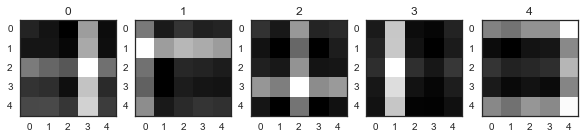

In [36]:
plot_images(plt, slda1.phi, (5, 5), (1, 5), figsize=(10, 5))

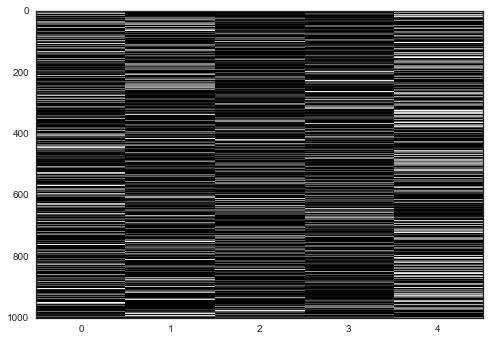

In [37]:
imshow(slda1.theta)

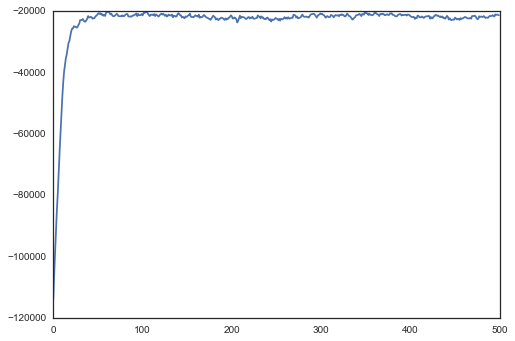

In [38]:
plt.plot(slda1.loglikelihoods)

In [39]:
burn_in1 = max(n_iter - 100, int(n_iter / 2))
slda1.loglikelihoods[burn_in1:].mean()

-22055.005897817184

In [40]:
eta_pred1 = slda1.eta[burn_in1:].mean(axis=0)
eta_pred1

array([  2.22220264,  -0.15788853,   9.55428965,  10.2525672 ,   3.22556876])

In [41]:
thetas_test_slda1 = slda1.transform(doc_term_matrix_test)
y_slda1 = [np.dot(eta_pred1, thetas_test_slda1[i]) for i in range(D)]

In [42]:
rmse(y_test, y_slda1)

1.2455951548532411

In [43]:
lda1 = LDA(_K, _alpha, _beta, n_iter, seed=42)

In [44]:
%%time
lda1.fit(doc_term_matrix)

2016-06-10 13:13:16.087473 start iterations
2016-06-10 13:13:16.143708 0:00:00.056235 elapsed, iter   10, LL -404994.8904, 13.25% change from last
2016-06-10 13:13:16.188322 0:00:00.100849 elapsed, iter   20, LL -380416.0984, 6.07% change from last
2016-06-10 13:13:16.232188 0:00:00.144715 elapsed, iter   30, LL -374718.7031, 1.50% change from last
2016-06-10 13:13:16.275514 0:00:00.188041 elapsed, iter   40, LL -372662.5340, 0.55% change from last
2016-06-10 13:13:16.318583 0:00:00.231110 elapsed, iter   50, LL -372592.3679, 0.02% change from last
2016-06-10 13:13:16.361522 0:00:00.274049 elapsed, iter   60, LL -371993.9718, 0.16% change from last
2016-06-10 13:13:16.404200 0:00:00.316727 elapsed, iter   70, LL -370991.9632, 0.27% change from last
2016-06-10 13:13:16.446894 0:00:00.359421 elapsed, iter   80, LL -372006.8433, -0.27% change from last
2016-06-10 13:13:16.490452 0:00:00.402979 elapsed, iter   90, LL -372236.5623, -0.06% change from last
2016-06-10 13:13:16.532751 0:00:00.

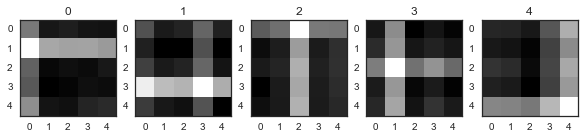

In [45]:
plot_images(plt, lda1.phi, (5, 5), (1, 5), figsize=(10, 5))

We plot the SLDA topics again and note that they are indeed different!

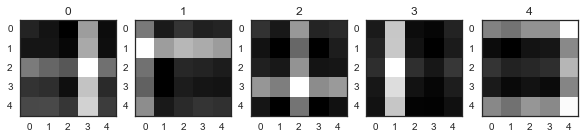

In [46]:
plot_images(plt, slda1.phi, (5, 5), (1, 5), figsize=(10, 5))

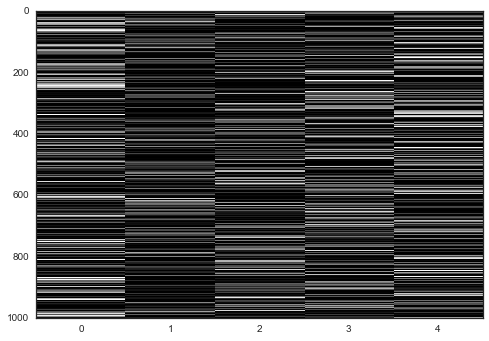

In [47]:
imshow(lda1.theta)

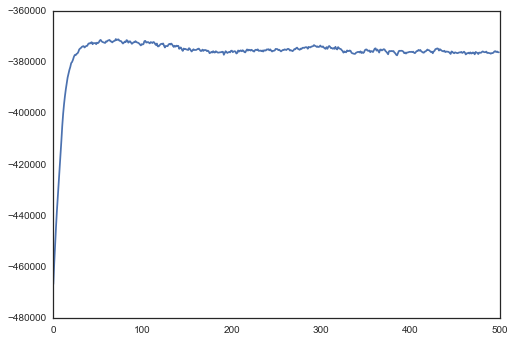

In [48]:
plt.plot(lda1.loglikelihoods)

In [49]:
thetas_test_lda1 = lda1.transform(doc_term_matrix_test)

#### Unregularized linear regression

In [50]:
lr1 = LinearRegression(fit_intercept=False)
lr1.fit(lda1.theta, y)
y_lr1 = lr1.predict(thetas_test_lda1)
rmse(y_test, y_lr1)

1.7255065570452643

#### L2-regularized linear regression

In [51]:
lrl21 = Ridge(alpha=1., fit_intercept=False)
lrl21.fit(lda1.theta, y)
y_lrl21 = lrl21.predict(thetas_test_lda1)
rmse(y_test, y_lrl21)

1.7266314501798159

#### Gradient boosted regression trees

In [52]:
gbr1 = GradientBoostingRegressor()
gbr1.fit(lda1.theta, y)
y_gbr1 = gbr1.predict(thetas_test_lda1)
rmse(y_test, y_gbr1)

1.790809644071969

#### Unregularized linear regression with SLDA topics

In [53]:
lr1_0 = LinearRegression(fit_intercept=False)
lr1_0.fit(slda1.theta, y)
y_lr1_0 = lr1_0.predict(thetas_test_slda1)
rmse(y_test, y_lr1_0)

1.2424204767358347

#### L2-regularized linear regression with SLDA topics

In [54]:
lrl21_0 = Ridge(alpha=1., fit_intercept=False)
lrl21_0.fit(slda1.theta, y)
y_lrl21_0 = lrl21_0.predict(thetas_test_slda1)
rmse(y_test, y_lrl21_0)

1.2497459065224035

#### Gradient boosted regression trees with SLDA topics

In [55]:
gbr1_0 = GradientBoostingRegressor()
gbr1_0.fit(slda1.theta, y)
y_gbr1_0 = gbr1_0.predict(thetas_test_slda1)
rmse(y_test, y_gbr1_0)

1.3036177236719277

### Conclusion for test with fewer topics

SLDA performs at least 27.5% better in root mean square error than any of the LDA-and-a-regression methods, and similar to the SLDA-and-a-linear-regression methods.